# Quick Start

See the [API](https://xskillscore.readthedocs.io/en/stable/api.html) for more detailed information, examples, formulas, and references for each function.

In [1]:
import numpy as np
import xarray as xr
import xskillscore as xs
import matplotlib.pyplot as plt
np.random.seed(seed=42)

/Users/aaron.spring/Coding/xskillscore/xskillscore/__init__.py:43: UserWarning: Module xskillscore was already imported from /Users/aaron.spring/Coding/xskillscore/xskillscore/__init__.py, but /Users/aaron.spring/anaconda3/envs/xskillscore-dev/lib/python3.8/site-packages/xskillscore-0.0.post431+dirty-py3.8.egg is being added to sys.path
  __version__ = get_distribution(__name__).version


Here, we generate some sample gridded data. Our data has three time steps, and a 4x5 latitude/longitude grid. `obs` denotes some verification data (sometimes termed `y`) and `fct` some forecast data (e.g. from a statistical or dynamical model; sometimes termed `yhat`).

In [2]:
obs = xr.DataArray(
       np.random.rand(3, 4, 5),
       coords=[
           xr.cftime_range("2000-01-01", "2000-01-03", freq="D"),
           np.arange(4),
           np.arange(5),
       ],
       dims=["time", "lat", "lon"],
       name='var'
   )
fct = obs.copy()
fct.values = np.random.rand(3, 4, 5)

## Deterministic Metrics

`xskillscore` offers a suite of correlation-based and distance-based deterministic metrics:

### Correlation-Based 

* Effective Sample Size (`effective_sample_size`)
* Pearson Correlation (`pearson_r`)
* Pearson Correlation effective p value (`pearson_r_eff_p_value`)
* Pearson Correlation p value (`pearson_r_p_value`)
* Slope of Linear Fit (`linslope`)
* Spearman Correlation (`spearman_r`)
* Spearman Correlation effective p value (`spearman_r_eff_p_value`)
* Spearman Correlation p value (`spearman_r_p_value`)

### Distance-Based

* Coefficient of Determination (`r2`)
* Mean Absolute Error (`mae`)
* Mean Absolute Percentage Error (`mape`)
* Mean Error (`me`)
* Mean Squared Error (`mse`)
* Median Absolute Error (`median_absolute_error`)
* Root Mean Squared Error (`rmse`)
* Symmetric Mean Absolute Percentage Error (`smape`)

Calling the functions is very straight-forward. All deterministic functions take the form `func(a, b, dim=None, **kwargs)`. **Notice that the original dataset is reduced by the dimension passed.** I.e., since we passed `time` as the dimension here, we are returned an object with dimensions `(lat, lon)`. For correlation metrics `dim` cannot be `[]`.

In [3]:
r = xs.pearson_r(obs, fct, dim='time')
print(r)

<xarray.DataArray 'var' (lat: 4, lon: 5)>
array([[ 0.99509676, -0.88499394,  0.94083077,  0.96521259, -0.13696899],
       [-0.90613709,  0.51585291,  0.72875703,  0.19331043,  0.79754067],
       [-0.80112059, -0.95632624, -0.23640403, -0.57684283,  0.43389289],
       [ 0.00230351, -0.58970109, -0.87332763, -0.99992557, -0.31404248]])
Coordinates:
  * lat      (lat) int64 0 1 2 3
  * lon      (lon) int64 0 1 2 3 4


In [4]:
p = xs.pearson_r_p_value(obs, fct, dim="time")
print(p)

<xarray.DataArray 'var' (lat: 4, lon: 5)>
array([[0.06306879, 0.30832471, 0.22009394, 0.1684121 , 0.91252786],
       [0.2780348 , 0.6549502 , 0.48019675, 0.87615511, 0.41226788],
       [0.40847506, 0.1888421 , 0.84806222, 0.60856901, 0.71427925],
       [0.99853354, 0.59849112, 0.32391484, 0.00776728, 0.79663312]])
Coordinates:
  * lat      (lat) int64 0 1 2 3
  * lon      (lon) int64 0 1 2 3 4


You can also specify multiple axes for deterministic metrics. Here, we apply it over the latitude and longitude dimension (a pattern correlation).

In [5]:
r = xs.pearson_r(obs, fct, dim=["lat", "lon"])
print(r)

<xarray.DataArray 'var' (time: 3)>
array([-0.16920304, -0.06326809,  0.18040449])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


All deterministic metrics except for `effective_sample_size`, `pearson_r_eff_p_value` and `spearman_r_eff_p_value` can take the kwarg `weights=...`. `weights` should be a DataArray of the size of the reduced dimension (e.g., if time is being reduced it should be of length 3 in our example).

Weighting is a common practice when working with observations and model simulations of the Earth system. When working with rectilinear grids, one can weight the data by the cosine of the latitude, which is maximum at the equator and minimum at the poles (as in the below example). More complicated model grids tend to be accompanied by a cell area varaible, which could also be passed into this function.

In [6]:
obs2 = xr.DataArray(
       np.random.rand(3, 180, 360),
       coords=[
           xr.cftime_range("2000-01-01", "2000-01-03", freq="D"),
           np.linspace(-89.5, 89.5, 180),
           np.linspace(-179.5, 179.5, 360),
       ],
       dims=["time", "lat", "lon"],
    )
fct2 = obs2.copy()
fct2.values = np.random.rand(3, 180, 360)

In [7]:
# make weights as cosine of the latitude and broadcast
weights = np.cos(np.deg2rad(obs2.lat))
_, weights = xr.broadcast(obs2, weights)

# Remove the time dimension from weights
weights = weights.isel(time=0)

In [8]:
r_weighted = xs.pearson_r(obs2, fct2, dim=["lat", "lon"], weights=weights)
print(r_weighted)

<xarray.DataArray (time: 3)>
array([-0.0020303 , -0.00498588, -0.00401522])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


In [9]:
r_unweighted = xs.pearson_r(obs2, fct2, dim=["lat", "lon"], weights=None)
print(r_unweighted)

<xarray.DataArray (time: 3)>
array([ 5.72646719e-05, -4.32380560e-03,  4.17909845e-05])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


You can also pass the optional boolean kwarg `skipna`. If `True`, ignore any NaNs (pairwise) in `obs` and `fct` when computing the result. If `False`, return NaNs anywhere there are pairwise NaNs.

In [10]:
obs_with_nans = obs.where(obs.lat > 1)
fct_with_nans = fct.where(fct.lat > 1)
print(obs_with_nans)

<xarray.DataArray 'var' (time: 3, lat: 4, lon: 5)>
array([[[       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan],
        [0.02058449, 0.96990985, 0.83244264, 0.21233911, 0.18182497],
        [0.18340451, 0.30424224, 0.52475643, 0.43194502, 0.29122914]],

       [[       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan],
        [0.60754485, 0.17052412, 0.06505159, 0.94888554, 0.96563203],
        [0.80839735, 0.30461377, 0.09767211, 0.68423303, 0.44015249]],

       [[       nan,        nan,        nan,        nan,        nan],
        [       nan,        nan,        nan,        nan,        nan],
        [0.96958463, 0.77513282, 0.93949894, 0.89482735, 0.59789998],
        [0.92187424, 0.0884925 , 0.19598286, 0.04522729, 0.32533033]]])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00
  * lat      (lat) 

In [11]:
mae_with_skipna = xs.mae(obs_with_nans, fct_with_nans, dim=['lat', 'lon'], skipna=True)
print(mae_with_skipna)

<xarray.DataArray 'var' (time: 3)>
array([0.51901116, 0.41623426, 0.32621064])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


In [12]:
mae_without_skipna = xs.mae(obs_with_nans, fct_with_nans, dim=['lat', 'lon'], skipna=False)
print(mae_without_skipna)

<xarray.DataArray 'var' (time: 3)>
array([nan, nan, nan])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


## Probabilistic Metrics

`xskillscore` offers a suite of probabilistic metrics:

* Brier Score (`brier_score`)
* Brier scores of an ensemble for exceeding given thresholds (`threshold_brier_score`)
* Continuous Ranked Probability Score with a gaussian distribution (`crps_gaussian`)
* Continuous Ranked Probability Score with numerical integration of the normal distribution (`crps_quadrature`)
* Continuous Ranked Probability Score with the ensemble distribution (`crps_ensemble`)
* Discrimination (`discrimination`)
* Rank Histogram (`rank_histogram`)
* Ranked Probability Score (`rps`)
* Receiver Operating Characteristic (`roc`)
* Reliability (`reliability`)

We now create some data with an ensemble member dimension. In this case, we envision an ensemble forecast with multiple members to validate against our theoretical observations:

In [13]:
obs3 = xr.DataArray(
       np.random.rand(4, 5),
       coords=[np.arange(4), np.arange(5)],
       dims=["lat", "lon"],
       name='var'
   )
fct3 = xr.DataArray(
       np.random.rand(3, 4, 5),
       coords=[np.arange(3), np.arange(4), np.arange(5)],
       dims=["member", "lat", "lon"],
       name='var'
   )

Continuous Ranked Probability Score with the ensemble distribution. Pass `dim=[]` to get the same behaviour as `properscoring.crps_ensemble` without any averaging over `dim`.

In [14]:
crps_ensemble = xs.crps_ensemble(obs3, fct3, dim=[])
print(crps_ensemble)

<xarray.DataArray 'var' (lat: 4, lon: 5)>
array([[0.19918258, 0.10670612, 0.11858151, 0.15974459, 0.26841063],
       [0.08038415, 0.13237479, 0.23778382, 0.18009214, 0.08326884],
       [0.08589149, 0.11666573, 0.21579228, 0.09646599, 0.12855359],
       [0.19891371, 0.10470738, 0.05289158, 0.107965  , 0.11143681]])
Coordinates:
  * lat      (lat) int64 0 1 2 3
  * lon      (lon) int64 0 1 2 3 4


The CRPS with a Gaussian distribution requires two parameters: $\mu$ and $\sigma$ from the forecast distribution. Here, we just use the ensemble mean and ensemble spread.

In [15]:
crps_gaussian = xs.crps_gaussian(obs3, fct3.mean("member"), fct3.std("member"), dim=[])
print(crps_gaussian)

<xarray.DataArray 'var' (lat: 4, lon: 5)>
array([[0.19821619, 0.11640329, 0.14219455, 0.15912935, 0.28104703],
       [0.08953392, 0.11758925, 0.25156378, 0.095484  , 0.10679842],
       [0.05069082, 0.07081479, 0.24529056, 0.08700853, 0.09535839],
       [0.1931706 , 0.11233935, 0.0783092 , 0.09593862, 0.11037143]])
Coordinates:
  * lat      (lat) int64 0 1 2 3
  * lon      (lon) int64 0 1 2 3 4


The CRPS quadrature metric requires a callable distribution function. Here we use `norm` from `scipy.stats`.

In [16]:
from scipy.stats import norm
crps_quadrature = xs.crps_quadrature(obs3, norm, dim=[])
print(crps_quadrature)

<xarray.DataArray (lat: 4, lon: 5)>
array([[0.52852898, 0.58042038, 0.46945497, 0.25013942, 0.23370234],
       [0.39109762, 0.24071855, 0.25557803, 0.28994381, 0.23764056],
       [0.40236669, 0.33477031, 0.24063375, 0.45538915, 0.48236113],
       [0.42011508, 0.4174865 , 0.24837346, 0.43954946, 0.44689198]])
Coordinates:
  * lat      (lat) int64 0 1 2 3
  * lon      (lon) int64 0 1 2 3 4


We can also use a threshold Brier Score, to score hits over a certain threshold. Ranked Probability Score for two categories yields the same result.

In [17]:
threshold_brier_score = xs.threshold_brier_score(obs3, fct3, 0.5, dim=None)
print(threshold_brier_score)

<xarray.DataArray 'var' ()>
array(0.15555556)
Coordinates:
    threshold  float64 0.5


In [18]:
brier_score = xs.brier_score(obs3>.5, (fct3>.5).mean('member'))
print(brier_score)

<xarray.DataArray 'var' ()>
array(0.15555556)


In [19]:
rps = xs.rps(obs3>.5, fct3>.5, category_edges=np.array([0.5]))
print(rps)

<xarray.DataArray ()>
array(0.15555556)


In [20]:
rank_histogram = xs.rank_histogram(obs3, fct3)
print(rank_histogram)

<xarray.DataArray 'histogram_rank' (rank: 4)>
array([3, 8, 6, 3])
Coordinates:
  * rank     (rank) float64 1.0 2.0 3.0 4.0


In [21]:
disc = xs.discrimination(obs3 > 0.5, (fct3 > 0.5).mean("member"))
print(disc)

<xarray.DataArray (event: 2, forecast_probability: 5)>
array([[0.        , 0.08333333, 0.        , 0.66666667, 0.25      ],
       [0.125     , 0.5       , 0.        , 0.375     , 0.        ]])
Coordinates:
  * forecast_probability  (forecast_probability) float64 0.1 0.3 0.5 0.7 0.9
  * event                 (event) bool True False


In [22]:
rel = xs.reliability(obs3 > 0.5, (fct3 > 0.5).mean("member"))
print(rel)

<xarray.DataArray 'var' (forecast_probability: 5)>
array([0.        , 0.2       ,        nan, 0.72727273, 1.        ])
Coordinates:
  * forecast_probability  (forecast_probability) float64 0.1 0.3 0.5 0.7 0.9
    samples               (forecast_probability) float64 1.0 5.0 0.0 11.0 3.0


0.8229166666666666

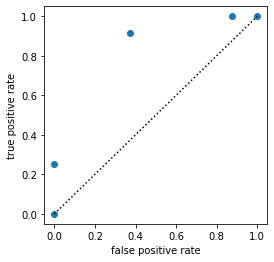

In [23]:
# ROC for probabilistic forecasts and bin_edges='continuous' default
roc = xs.roc(obs3 > 0.5, (fct3 > 0.5).mean("member"), return_results='all_as_metric_dim')

plt.figure(figsize=(4, 4))
plt.plot([0, 1], [0, 1], 'k:')
roc.to_dataset(dim='metric').plot.scatter(y='true positive rate', x='false positive rate')
roc.sel(metric='area under curve').values[0]

## Contingency-Based

To work with contingency-based scoring, first instantiate a `Contingency` object by passing in your observations, forecast, and observation/forecast bin edges. See https://www.cawcr.gov.au/projects/verification/#Contingency_table for more information.

In [24]:
dichotomous_category_edges = np.array([0, 0.5, 1])  # "dichotomous" mean two-category
dichotomous_contingency = xs.Contingency(
    obs, fct, dichotomous_category_edges, dichotomous_category_edges, dim=["lat", "lon"]
)
dichotomous_contingency_table = dichotomous_contingency.table
print(dichotomous_contingency_table)

<xarray.DataArray 'histogram_observations_forecasts' (time: 3, observations_category: 2, forecasts_category: 2)>
array([[[5, 6],
        [6, 3]],

       [[6, 5],
        [4, 5]],

       [[5, 5],
        [4, 6]]])
Coordinates:
  * time                          (time) object 2000-01-01 00:00:00 ... 2000-...
    observations_category_bounds  (observations_category) <U10 '[0.0, 0.5)' '...
    forecasts_category_bounds     (forecasts_category) <U10 '[0.0, 0.5)' '[0....
  * observations_category         (observations_category) int64 1 2
  * forecasts_category            (forecasts_category) int64 1 2


In [25]:
print(
    dichotomous_contingency_table.to_dataframe()
    .pivot_table(
        index=["forecasts_category", "forecasts_category_bounds"],
        columns=["observations_category", "observations_category_bounds"],
    )
    .round(2)
)

                                             histogram_observations_forecasts  \
observations_category                                                       1   
observations_category_bounds                                       [0.0, 0.5)   
forecasts_category forecasts_category_bounds                                    
1                  [0.0, 0.5)                                            5.33   
2                  [0.5, 1.0]                                            5.33   

                                                         
observations_category                                 2  
observations_category_bounds                 [0.5, 1.0]  
forecasts_category forecasts_category_bounds             
1                  [0.0, 0.5)                      4.67  
2                  [0.5, 1.0]                      4.67  


Scores based on the constructed contingency table can be called via class methods. The available methods are:

* Accuracy (`accuracy`)
* Bias Score (`bias_score`)
* Equitable Threat Score (`equit_threat_score`)
* False Alarms / False Positives (`false_alarms`)
* False Alarm Ratio / False Discovery Rate (`false_alarm_ratio`)
* False Alarm Rate / False Positive Rate / Fall-out (`false_alarm_rate`)
* Gerrity Score (`gerrity_score`)
* Heidke Score / Cohen's Kappa (`heidke_score`)
* Hit Rate / Recall / Sensitivity / True Positive Rate (`hit_rate`)
* Hits / True Positives (`hits`)
* Misses / False Negatives (`misses`)
* Odds Ratio (`odds_ratio`)
* Odds Ratio Skill Score (`odds_ratio_skill_score`)
* Peirce Score (`peirce_score`)
* Receiver Operating Characteristic (`roc`)
* Success Ratio / Precision / Positive Predictive Value (`success_ratio`)
* Threat Score / Critical Success Index (`threat_score`)

Below, we share a few examples of these in action:

In [26]:
print(dichotomous_contingency.bias_score())

<xarray.DataArray 'histogram_observations_forecasts' (time: 3)>
array([1.        , 1.11111111, 1.1       ])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


In [27]:
print(dichotomous_contingency.hit_rate())

<xarray.DataArray 'histogram_observations_forecasts' (time: 3)>
array([0.33333333, 0.55555556, 0.6       ])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


In [28]:
print(dichotomous_contingency.false_alarm_rate())

<xarray.DataArray 'histogram_observations_forecasts' (time: 3)>
array([0.54545455, 0.45454545, 0.5       ])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


In [29]:
print(dichotomous_contingency.odds_ratio_skill_score())

<xarray.DataArray 'histogram_observations_forecasts' (time: 3)>
array([-0.41176471,  0.2       ,  0.2       ])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


Now we can leverage multi-category edges to make use of some scores.

In [30]:
multi_category_edges = np.array([0, 0.25, 0.75, 1])
multicategory_contingency = xs.Contingency(
    obs, fct, multi_category_edges, multi_category_edges, dim=["lat", "lon"]
)

In [31]:
print(multicategory_contingency.accuracy())

<xarray.DataArray 'histogram_observations_forecasts' (time: 3)>
array([0.25, 0.25, 0.5 ])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


In [32]:
print(multicategory_contingency.heidke_score())

<xarray.DataArray 'histogram_observations_forecasts' (time: 3)>
array([-0.14503817, -0.25      ,  0.2481203 ])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


In [33]:
print(multicategory_contingency.peirce_score())

<xarray.DataArray 'histogram_observations_forecasts' (time: 3)>
array([-0.1496063 , -0.24193548,  0.25      ])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


In [34]:
print(multicategory_contingency.gerrity_score())

<xarray.DataArray 'histogram_observations_forecasts' (time: 3)>
array([-0.15212912, -0.11160714,  0.25      ])
Coordinates:
  * time     (time) object 2000-01-01 00:00:00 ... 2000-01-03 00:00:00


0.5035528250988777

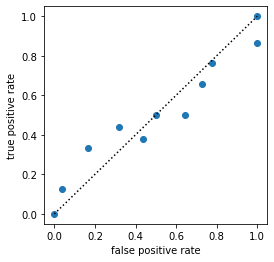

In [35]:
# ROC for deterministic forecasts and bin_edges
roc = xs.roc(obs, fct, np.linspace(0, 1, 11), return_results='all_as_metric_dim')

plt.figure(figsize=(4, 4))
plt.plot([0,1], [0,1], 'k:')
roc.to_dataset(dim='metric').plot.scatter(y='true positive rate', x='false positive rate')
roc.sel(metric='area under curve').values[0]

## Comparative

Tests to compare whether one forecast is significantly better than another one.

### Sign test

In [36]:
length = 100
obs_1d = xr.DataArray(
       np.random.rand(length),
       coords=[
           np.arange(length),
       ],
       dims=["time"],
       name='var'
   )
fct_1d = obs_1d.copy()
fct_1d.values = np.random.rand(length)

In [37]:
# given you want to test whether one forecast is better than another forecast
significantly_different, walk, confidence = xs.sign_test(
    fct_1d, fct_1d + 0.2, obs_1d, time_dim="time", metric="mae", orientation="negative"
)

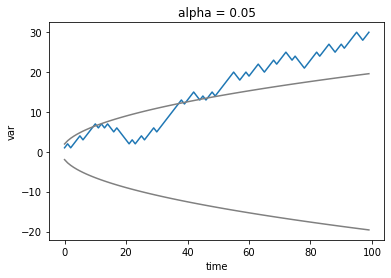

In [38]:
walk.plot()
confidence.plot(c='gray')
(-1 * confidence).plot(c='gray')

### Half-width Confidence Interval test

In [39]:
# create a worse forecast with high but different to perfect correlation and choose RMSE as the distance metric
fct_1d_worse = fct_1d.copy()
step = 3
fct_1d_worse[::step] = fct_1d[::step].values + 0.1
metric = "rmse"

In [40]:
# half-with of the confidence interval at level alpha is larger than the RMSE differences,
# therefore not significant
alpha = 0.05
significantly_different, diff, hwci = xs.halfwidth_ci_test(
    fct_1d, fct_1d_worse, obs_1d, metric, time_dim="time", dim=[], alpha=alpha
)
print(diff)
print(hwci)
print(
    f"RMSEs significantly different at level {alpha} : {bool(significantly_different)}"
)

<xarray.DataArray 'var' ()>
array(0.00734139)
<xarray.DataArray 'var' ()>
array(0.01108879)
RMSEs significantly different at level 0.05 : False


## Statistical tests

### Multiple tests

A statistical test is applied multiple times on a spatial grid. `multipletests` helps controlling the false discovery rate (FDR) of p values.

In [41]:
p = xs.pearson_r_p_value(fct, obs, 'time')
print(p)

<xarray.DataArray 'var' (lat: 4, lon: 5)>
array([[0.06306879, 0.30832471, 0.22009394, 0.1684121 , 0.91252786],
       [0.2780348 , 0.6549502 , 0.48019675, 0.87615511, 0.41226788],
       [0.40847506, 0.1888421 , 0.84806222, 0.60856901, 0.71427925],
       [0.99853354, 0.59849112, 0.32391484, 0.00776728, 0.79663312]])
Coordinates:
  * lat      (lat) int64 0 1 2 3
  * lon      (lon) int64 0 1 2 3 4


In [42]:
p_corrected = xs.multipletests(p, alpha=.5, method='fdr_bh',return_results='pvals_corrected')

In [43]:
assert not p_corrected.equals(p)

## Accessors

You can also use `xskillscore` as a method of your `xarray` Dataset.

In [44]:
ds = xr.Dataset()
ds["obs_var"] = obs
ds["fct_var"] = fct

In the case that your Dataset contains both your observation and forecast variable, just pass them as strings into the function.

In [45]:
print(ds.xs.pearson_r("obs_var", "fct_var", dim="time"))

<xarray.DataArray (lat: 4, lon: 5)>
array([[ 0.99509676, -0.88499394,  0.94083077,  0.96521259, -0.13696899],
       [-0.90613709,  0.51585291,  0.72875703,  0.19331043,  0.79754067],
       [-0.80112059, -0.95632624, -0.23640403, -0.57684283,  0.43389289],
       [ 0.00230351, -0.58970109, -0.87332763, -0.99992557, -0.31404248]])
Coordinates:
  * lat      (lat) int64 0 1 2 3
  * lon      (lon) int64 0 1 2 3 4


You can also pass in a separate Dataset that contains your observations or forecast variable.

In [46]:
ds = ds.drop_vars("fct_var")
print(ds.xs.pearson_r("obs_var", fct, dim="time"))

<xarray.DataArray (lat: 4, lon: 5)>
array([[ 0.99509676, -0.88499394,  0.94083077,  0.96521259, -0.13696899],
       [-0.90613709,  0.51585291,  0.72875703,  0.19331043,  0.79754067],
       [-0.80112059, -0.95632624, -0.23640403, -0.57684283,  0.43389289],
       [ 0.00230351, -0.58970109, -0.87332763, -0.99992557, -0.31404248]])
Coordinates:
  * lat      (lat) int64 0 1 2 3
  * lon      (lon) int64 0 1 2 3 4


## Resampling
-   randomly resample the `time` dimension and then take mean over `time` to get resample threshold
-   resample over `member` dimension to get uncertainty due to member sampling in hindcasts

In [47]:
# create large one-dimensional array
s = 1000
f = xr.DataArray(
    np.random.normal(size=s), dims="member", coords={"member": np.arange(s)}, name="var"
)

In [48]:
# resample with replacement in that one dimension
iterations = 100
%timeit f_r = xs.resampling.resample_iterations(f, iterations, 'member', replace=True)
# resample_iterations_idx is much (50x) faster because it involves no loops
%timeit f_r = xs.resampling.resample_iterations_idx(f, iterations, 'member', replace=True)
# but both do the same resampling

61.9 ms ± 6.26 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
1.39 ms ± 39.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


- use `resample_iterations` for very large data, because very robust, chunksize stays contants and only more tasks are added
- use `resample_iterations_idx` for small data always and very large data only, when chunked to small chunks in the other dimensions, because the function increases the input chunksize by factor `iterations`

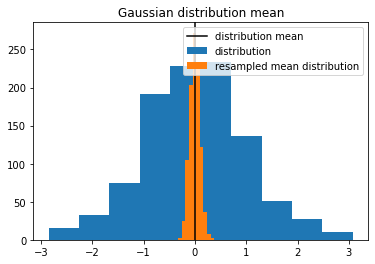

In [49]:
f_r = xs.resampling.resample_iterations_idx(f, iterations, 'member', replace=True)
f.plot.hist(label='distribution')
f_r.mean('iteration').plot.hist(label='resampled mean distribution')
plt.axvline(x=f.mean('member'), c='k', label='distribution mean')
plt.title('Gaussian distribution mean')
plt.legend()

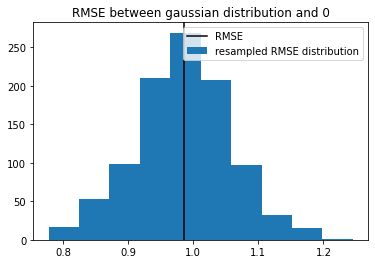

In [50]:
# we can calculate the distribution of the RMSE of 0 and f resampled over member
xs.rmse(f_r, xr.zeros_like(f_r), dim='iteration').plot.hist(label='resampled RMSE distribution')
# the gaussian distribution should have an RMSE with 0 of one
plt.axvline(x=xs.rmse(f, xr.zeros_like(f)), c='k', label='RMSE')
plt.title('RMSE between gaussian distribution and 0')
plt.legend()